In [1]:
from qiskit import *
from numpy.random import randint, shuffle
from qiskit.visualization import plot_histogram, plot_bloch_multivector
import numpy as np

In [2]:
def bit_string(n):
    zeros = [0 for _ in range(n//2)]
    ones = [1 for _ in range(n - n//2)]
    bits = zeros + ones
    np.random.shuffle(bits)
    return bits

In [3]:
def encode_bits1(bits, bases):
    base_encoding = []
    for bit, base in zip(bits, bases):
        base_circuit = QuantumCircuit(1, 1)
        if base == 0:
            if bit == 1:
                base_circuit.x(0)
        if base == 1:
            if bit == 0:
                base_circuit.h(0)
            if bit == 1:
                base_circuit.x(0)
                base_circuit.h(0)
        base_circuit.barrier()
        base_encoding.append(base_circuit)
    return base_encoding

In [39]:
def encode_bits(bits, bases):
    l = len(bits)
    base_circuit = QuantumCircuit(l, l)
    for i in range(l):
        if bases[i] == 0:
            if bits[i] == 1:
                base_circuit.x(i)
        if bases[i] == 1:
            if bits[i] == 0:
                base_circuit.h(i)
            if bits[i] == 1:
                base_circuit.x(i)
                base_circuit.h(i)
    base_circuit.barrier()
    return base_circuit

In [5]:
def measure_bits1(bits, bases):
    backend = Aer.get_backend('qasm_simulator')
    measured_bits = []
    for j in range(len(bits)):
        if bases[j] == 0:
            bits[j].measure(0,0)
        if bases[j] == 1:
            bits[j].h(0)
            bits[j].measure(0,0)
        result = execute(bits[j], backend, shots=1, memory = True).result()
        measured_bit = int(result.get_memory()[0])
        measured_bits.append(measured_bit)
    return measured_bits

In [6]:
def measure_bits(bits, bases):
    backend = Aer.get_backend('qasm_simulator')
    for j in range(len(bases)):
        if bases[j] == 0:
            bits.measure(j,j)
        if bases[j] == 1:
            bits.h(j)
            bits.measure(j,j)
    r = execute(bits, backend, shots=1, memory = True).result().get_counts()
    return bits, [int(ch) for ch in list(r.keys())[0]]

In [7]:
def agreed_bases(a, b):
    return [j for j in range(len(a)) if a[j] == b[j]]

In [8]:
def select_bits(bits, selection, test):
    return [i for i in range(len(selection)) if selection[i] == test]

In [9]:
def error_rate(atest, btest):
    W = len([j for j in range(len(atest)) if atest[j] != btest[j]])
    return W / len(atest)

In [10]:
def information_reconciliation(a, b):
    return a, b

In [11]:
def toeplitz(n, k, bits):
    seed = bit_string(n + k - 1)
    matrix = np.zeros((k, n), dtype = int)
    for i in range(k) :
        for j in range(n) :
            matrix[i,j] = seed[i - j + n - 1]
    key = np.matmul(matrix, np.transpose((np.array(bits))))
    return [bit%2 for bit in key]

In [12]:
def QCC(bits) :
    return bits

In [13]:
def CAC(bits) :
    return bits

In [47]:
n = 8
N = 32

#Step 1 - Dev generates bits
dev_bits = bit_string(N)
print(dev_bits)

#Step 2 - Dev generates the bases string
dev_bases = bit_string(N)
print(dev_bases)

#Step 3 - Abhi generates the bases string
abhi_bases = bit_string(N)
print(abhi_bases)

[0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1]
[0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1]


|Information|Dev|Kaal|Abhi|
|:-:|:-:|:-:|:-:|
|Dev's bits|Y|N|N|
|Dev's bases|Y|N|N|
|Abhi's bases|N|Y|N|

[0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0]
[0, 1, 2, 6, 7, 8, 11, 13, 14, 15, 16, 17, 19, 20, 25, 28, 29, 31]


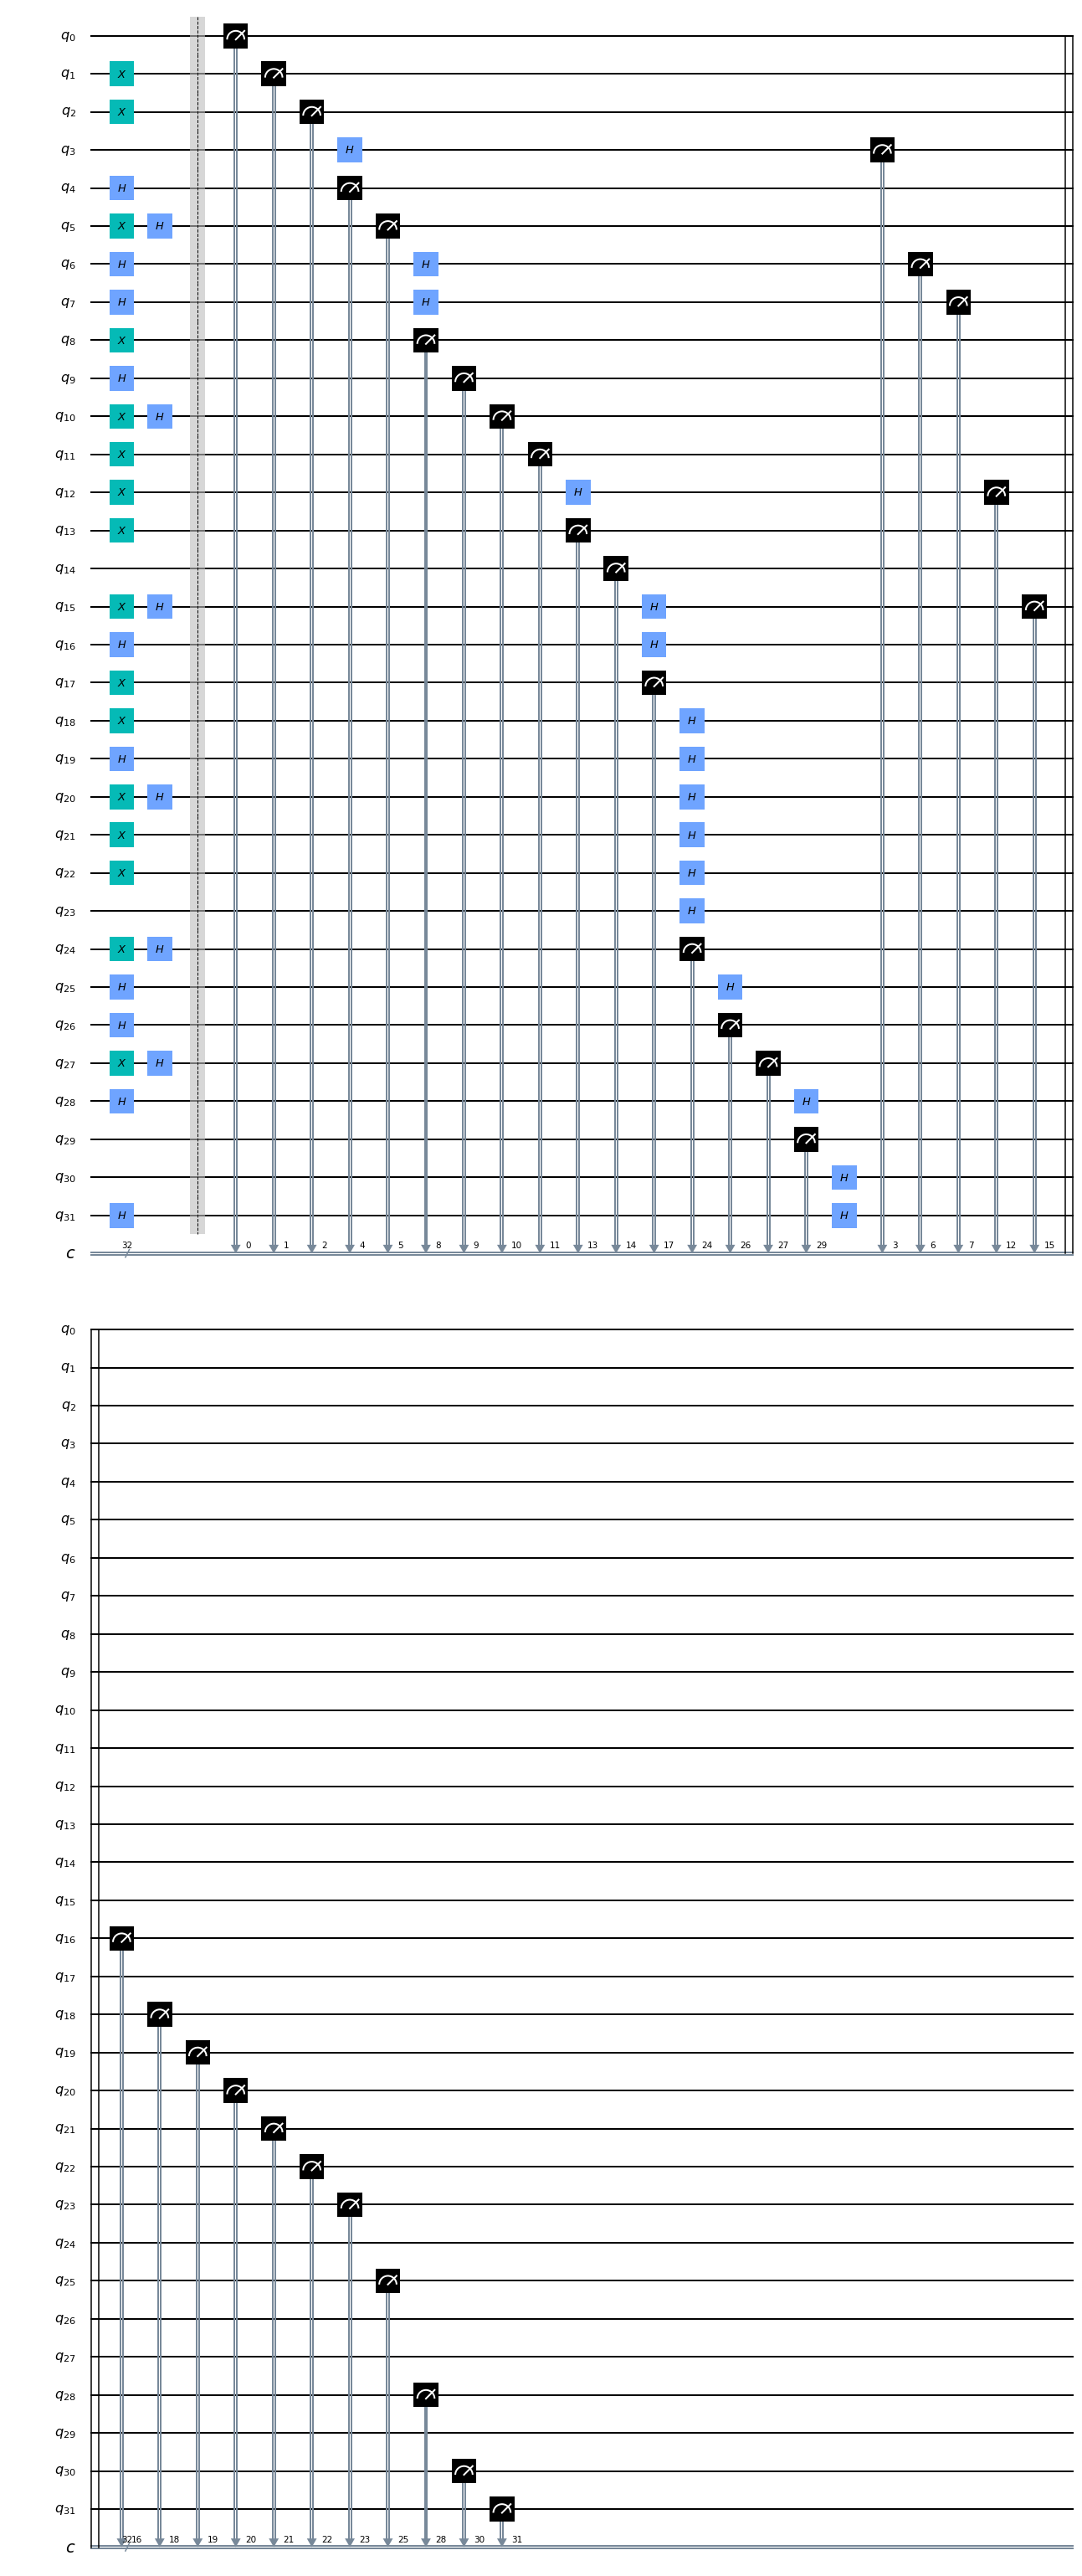

In [48]:
#Step 4 - Dev encodes his bits in the chosen bases 
dev_encode = encode_bits(dev_bits, dev_bases)

#Step 5 - Dev sends his encoded bits to Abhi and Kaal tries to intercept over the Quantum channel
received_encode = QCC(dev_encode)

#Step 6 - Abhi measures Dev's bits in the chosen bases
abhi_circuit, abhi_bits = measure_bits(received_encode, abhi_bases)
print(abhi_bits)

#Step 7 - Abhi announces that he has received the encoding and measured it over CAC

#Step 8 - Dev and Abhi exchange their bases over CAC
d2a = CAC(dev_bases)
a2d = CAC(abhi_bases)

#Step 9 - Dev and Abhi discard all the bits that correspond to disagreed bases
agreed_base_indices = agreed_bases(dev_bases, abhi_bases)
print(agreed_base_indices)
abhi_circuit.draw(output = 'mpl')

|Information|Dev|Kaal|Abhi|
|:-:|:-:|:-:|:-:|
|Dev's Encoding|Y|Partial|Noisy|
|Abhi's bits|N|N|Y|
|Dev's and Abhi's bases|Y|Y|Y|

In [ ]:
#Step 10 - Error rate checking 
S2T = bit_string(len(agreed_base_indices))
print(S2T)
T = select_bits(agreed_base_indices, S2T, 0)
print(T)
#Step 11 - Dev tells T to Abhi over CAC
abhi_T = CAC(T)
print(abhi_T)
#Step 12 - Dev and Abhi generate their test bits 
dev_test_bits = [dev_bits[i] for i in T]
abhi_test_bits = [abhi_bits[i] for i in abhi_T]
print(dev_test_bits)
print(abhi_test_bits)

#Step 12 - Dev and Abhi announce their test bits to each other over the CAC

#Step 13 - Dev and Abhi compute the error rate
error = error_rate(dev_test_bits, abhi_test_bits)
print(error)

[1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 

|Information|Dev|Kaal|Abhi|
|:-:|:-:|:-:|:-:|
|T|Y|Y|Y|
|Dev's test bits|Y|Y|Y|
|Abhi's test bits|Y|Y|Y|

In [ ]:
#Step 14 - Dev and Abhi check over a threshold for error before proceeding ahead
if error > 0.11 :
    print ("Abort")
else :
    #Step 15 - Dev and Abhi generate their pseudo keys
    SminusT = select_bits(agreed_base_indices, S2T, 1)
    dev_pseudokey = [dev_bits[i] for i in SminusT]
    abhi_pseudokey = [abhi_bits[i] for i in SminusT]

    #Step 16 - Dev and Abhi perform Information Reconciliation
    dev_reconcile = dev_pseudokey
    abhi_reconcile = abhi_pseudokey

    #Step 17 - Dev and Abhi perform privacy amplification
    dev_key = toeplitz(len(dev_reconcile), len(dev_reconcile) / 2, dev_reconcile)
    abhi_key = toeplitz(len(dev_reconcile), len(dev_reconcile) / 2, abhi_reconcile)

Abort


|Information|Dev|Kaal|Abhi|
|:-:|:-:|:-:|:-:|
|Pseudo key|Y|Partial|Noisy|